causal exploration
https://www.datacamp.com/tutorial/intro-to-causal-ai-using-the-dowhy-library-in-python
https://www.pywhy.org/

conda install numpy pandas dowhy


Para gráficos 
Descarga e instala Graphviz desde la página oficial:
https://graphviz.org/download/
Elige la versión para Windows (por ejemplo, Graphviz 2.46.0 o superior).

Durante la instalación, asegúrate de que la opción para agregar Graphviz al PATH esté seleccionada, o agrégalo manualmente a la variable de entorno PATH después.

Para verificar que Graphviz está instalado correctamente, abre una consola (CMD o PowerShell) y ejecuta: 
consola:  dot --version

instalamos: 
conda install -c conda-forge pygraphviz
pip install matplotlib


In [1]:
import numpy as np
import pandas as pd
import dowhy

working with simulated data when studying causal AI is that we have full control over the data generating process and knowledge of the “ground truth,” which wouldn’t be the case with real-world data.

In [2]:
from dowhy import CausalModel
import dowhy.datasets

# Set seed to enable exact replication
np.random.seed(1)

# Simulate sample data
data = dowhy.datasets.linear_dataset(
    beta=1,
    num_common_causes=2,
    num_discrete_common_causes=1,
    num_instruments=1,
    num_samples=10000,
    treatment_is_binary=True)

df = data['df']

Treatment (v0),

Outcome (y),

Common causes/confounders (W0, W1),

Instrumental variable (Z0)

The causal relationships are encoded in a graph stored as a GML string in data['gml_graph']

cambiamos los nombres de las variables:


In [3]:
gml_graph = data["gml_graph"]
gml_graph = gml_graph.replace('v0', 'Trabajo_en_casa')
gml_graph = gml_graph.replace('y', 'Productivity')
gml_graph = gml_graph.replace('W0', 'Introvertido')
gml_graph = gml_graph.replace('W1', 'Hijos')
gml_graph = gml_graph.replace('Z0', 'Instrument')


In [4]:
df = df.rename(columns={
    'v0': 'Trabajo_en_casa',
    'y': 'Productivity',
    'W0': 'Introvertido',
    'W1': 'Hijos',
    'Z0': 'Instrument'
})


In [5]:
print(gml_graph)


graph[directed 1node[ id "Productivity" label "Productivity"]node[ id "Introvertido" label "Introvertido"] node[ id "Hijos" label "Hijos"]node[ id "Instrument" label "Instrument"]node[ id "Trabajo_en_casa" label "Trabajo_en_casa"]edge[source "Trabajo_en_casa" target "Productivity"]edge[ source "Introvertido" target "Trabajo_en_casa"] edge[ source "Hijos" target "Trabajo_en_casa"]edge[ source "Instrument" target "Trabajo_en_casa"]edge[ source "Introvertido" target "Productivity"] edge[ source "Hijos" target "Productivity"]]


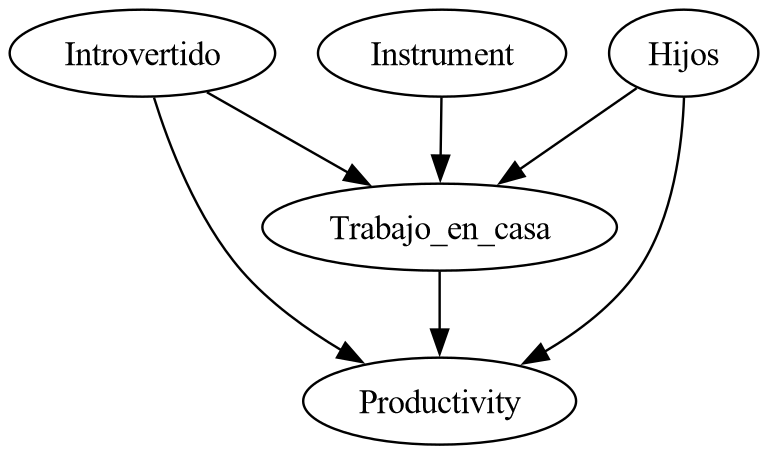

In [6]:
from dowhy import CausalModel
from IPython.display import Image, display

# Create the causal model
model = CausalModel(
    data=df,
    treatment='Trabajo_en_casa',
    outcome='Productivity',
    graph=gml_graph  # your modified graph string with renamed variables
)

# Visualize the causal graph and save as PNG
model.view_model(layout="dot")  # This generates 'causal_model.png' in your working directory

# Display the graph inline in the notebook
display(Image(filename="causal_model.png"))


let’s benchmark it with what a naive approach based on a simple linear prediction algorithm would tell us

The slope coefficient in a bivariate regression is equal to 1.298. However, we know that the true causal effect is actually equal to one, as we have generated the data in this manner.

The dowhy.datasets.linear_dataset function generates synthetic data according to a linear structural causal model with additive noise, using mostly Gaussian (normal) distributions for the variables and noise terms. 

Some parameters could be changed

In [7]:
# Run a linear regression of column y on v0 in df
import statsmodels.api as sm

X = df['Trabajo_en_casa'].astype(float)
y = df['Productivity'].astype(float)

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()

# Display a more parsimonious results summary
print(ols.summary().tables[1])

#The slope coefficient in a bivariate regression is equal to 1.298. 
# However, we know that the true causal effect is actually equal to one, as we have generated the data in this manner.

                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7966      0.017     47.194      0.000       0.764       0.830
Trabajo_en_casa     1.2947      0.022     59.804      0.000       1.252       1.337


In [8]:
# Check whether causal effect is identified and return target estimands
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                             
──────────────────(E[Productivity|Introvertido,Hijos])
d[Trabajo_en_casa]                                    
Estimand assumption 1, Unconfoundedness: If U→{Trabajo_en_casa} and U→Productivity then P(Productivity|Trabajo_en_casa,Introvertido,Hijos,U) = P(Productivity|Trabajo_en_casa,Introvertido,Hijos)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                              -1⎤
 ⎢      d                     ⎛      d                         ⎞  ⎥
E⎢─────────────(Productivity)⋅⎜─────────────([Trabajo_en_casa])⎟  ⎥
 ⎣d[Instrument]               ⎝d[Instrument]                   ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Productivity then ¬(U →→{Instrument})
Estimand assumption 2, Exclusion: If we remove {Instrument}→{Trabajo_en_casa}, then ¬({Instrument}→Productivity)

### Estimand : 3
Esti